## Introduction

In this document I start with an illustration to show that the reparameterization used, although it repairs any warnings of collinearity, didn't actually change the fit or any other behavior of the model.  This is under the assumption that the equivalent contrasts are used in the two model setups.  Notably, when orthogonalization is used (you likely never ever need to use it outside of mean centering things), interpretations can change dramatically, although model fit is the same.  I'm not going into that here, but wanted to mention it since it is a type of model reparameterization that can have very negative results.

After that I dig into possible consequences of different RT modeling strategies.

### Design setup: equivalence of models when changing to parametrically modulated regressors

Here I use the simple example to two task types.  I'll show high collinearity and low collinearity cases to illustrate equivalence of contrast estimates and their t-statistics.  Notably, in some cases the contrasts may be off by a factor, but this will "come out in the wash" in the t-statistics. Specifically in this case it is off by a factor of 2 and that's fine.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nistats import hemodynamic_models
import statsmodels.api as sm
from scipy.stats import t

# Plopping this into a function since I want to look at high/low collinearity
# Simple design where collinearity will be driven by proximity of onsets.  
# 10 stimuli of each type,10s apart, 1s long.  
# There are two stimulus types that alternate

# This function will output 2 sets of regressors: one for the 1 
#   regressor per trial type model setup
# The second is for the parametrically modulated model setup.

def make_des(onsetdiff):
    #onsetdiff is difference in onset time for trial 
    # type 2 vs 1. Trials alternate
    frame_times = np.arange(0, 100, 1)

    # generate an HDR timeseries for each of 2 conditions occuring every 10 seconds
    # for 100 seconds, separated in time by onsetdiff seconds.

    onsets1a = np.arange(1, 100, 10)
    onsets1b = onsets1a + onsetdiff

    durs1 = amps1 = np.ones(len(onsets1a), dtype=np.int8)

    exp_condition1a =  [onsets1a, durs1, amps1]
    exp_condition1b = [onsets1b, durs1, amps1]


    reg1a, name = hemodynamic_models.compute_regressor(
        exp_condition1a, 'spm', frame_times, oversampling = 16)
    reg1b, name = hemodynamic_models.compute_regressor(
        exp_condition1b, 'spm', frame_times, oversampling = 16)
    des1 = np.c_[reg1a.T[0], reg1b.T[0]]

    # create a task HRD timeseries and a parametric timeseries

    onsets2 = np.sort(np.concatenate([onsets1a, onsets1b]))
    durs2 = amps_nomod = np.ones(len(onsets2))
    amps_mod = np.tile(np.array([1,-1]), int(len(durs2)/2))

    exp_condition2_nomod = [onsets2, durs2, amps_nomod]
    exp_condition2_mod = [onsets2, durs2, amps_mod]

    reg2_nomod, name = hemodynamic_models.compute_regressor(
            exp_condition2_nomod, 'spm', frame_times, oversampling = 16)
    reg2_mod, name = hemodynamic_models.compute_regressor(
            exp_condition2_mod, 'spm', frame_times, oversampling = 16)
    des2 = np.c_[reg2_nomod.T[0], reg2_mod.T[0]]
    
    return des1, des2, frame_times


/Users/henrymj/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/Users/henrymj/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/henrymj/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base modu

Generate design matrices for low collinearity case and plot regressors.  Don't worry about any scaling issues.  

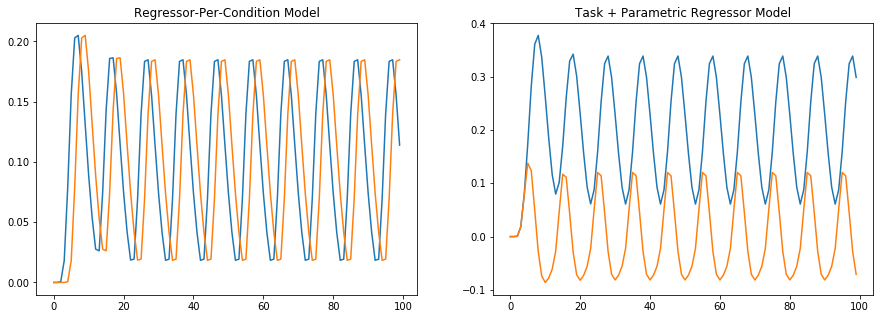

In [16]:
des_unmod, des_mod, frame_times = make_des(2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.plot(frame_times, des_unmod.T[0])
ax1.plot(frame_times, des_unmod.T[1])
ax1.set_title("Regressor-Per-Condition Model")


ax2.plot(frame_times, des_mod.T[0])
ax2.plot(frame_times, des_mod.T[1])
_ = ax2.set_title("Task + Parametric Regressor Model") # `_ =` stops the print out of the text below 



### I wrote this function so I could estimate contrasts and their t-statistics so we could easily compare our two models.  Also, a VIF function.

In [41]:
def runreg(y, x, contrast):
    inv_xt_x = np.linalg.inv(np.dot(x.T, x))
    beta_hat = np.dot(inv_xt_x, np.dot(x.T, y))
    residual = y - np.dot(x, beta_hat)
    df = x.shape[0] - x.shape[1]
    sigma = np.sqrt(sum(residual**2)/df)
    con_est = np.dot(contrast, beta_hat)
    con_t = con_est/(
        np.sqrt(
            np.dot(contrast, np.dot(inv_xt_x, contrast.T)))
            * sigma
            )
    return con_est, con_t

def vif(desmat):
    vif_est = np.diagonal(np.linalg.inv(np.corrcoef(desmat.T)))
    return vif_est

### VIFs are decent for both models here, since collinearity is low.

In [19]:
print(vif(des_unmod))
print(vif(des_mod))

[1.13925567 1.13925567]
[1.00044763 1.00044763]


### Model estimates are identical.  Note the contrasts only differ by a scalar factor of 2, but t-stats are identical.  This isn't an issue.



In [42]:
# Make some fake data -  True difference is 3
bold = 1 + 2*des_unmod.T[0] - 1*des_unmod.T[1] + \
    np.random.normal(0, .1, size = len(des_unmod.T[0]))

# unmodulated regressors

des_unmod_w_int = sm.add_constant(des_unmod)
est1 = sm.OLS(bold, des_unmod_w_int).fit()

con_mod1 = np.array([0, 1, -1])
con_est1, con_t1 = runreg(bold, des_unmod_w_int, con_mod1)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Unmodulated model: contrast est = {}, t  = {}".format( \
                                                    round(con_est1, 3), \
                                                    round(con_t1, 3)))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")



des_mod_w_int = sm.add_constant(des_mod)
est2 = sm.OLS(bold, des_mod_w_int).fit()

con_mod2 = np.array([0, 0, 1])
con_est2, con_t2 = runreg(bold, des_mod_w_int, con_mod2)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Modulated model: contrast est = {}, t  = {}".format( \
                                                    round(con_est2, 3),\
                                                     round(con_t2, 3)))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Unmodulated model: contrast est = 3.173, t  = 11.26
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Modulated model: contrast est = 1.587, t  = 11.26
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Full model output to convince you everything is matched.

In [43]:
print('Unmodulated Model')
print(est1.summary())
print("Modulated model")
print(est2.summary())

Unmodulated Model
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     75.38
Date:                Wed, 21 Oct 2020   Prob (F-statistic):           1.77e-20
Time:                        12:41:23   Log-Likelihood:                 87.346
No. Observations:                 100   AIC:                            -168.7
Df Residuals:                      97   BIC:                            -160.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9958      0.022  

### Verify that the equivalence isn't impacted by high collinearity.

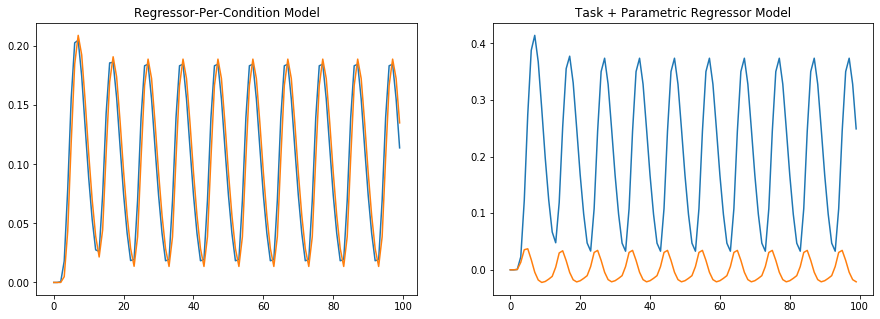

In [44]:
des_unmod, des_mod, frame_times = make_des(.5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.plot(frame_times, des_unmod.T[0])
ax1.plot(frame_times, des_unmod.T[1])
ax1.set_title("Regressor-Per-Condition Model")


ax2.plot(frame_times, des_mod.T[0])
ax2.plot(frame_times, des_mod.T[1])
_ = ax2.set_title("Task + Parametric Regressor Model")


In [45]:
print("~~~~~~~~~~~~~~~VIFs~~~~~~~~~~~~~~")
print(vif(des_unmod))
print(vif(des_mod))

~~~~~~~~~~~~~~~VIFs~~~~~~~~~~~~~~
[10.53332589 10.53332589]
[1.00041523 1.00041523]


In [46]:
# Simulate data - true difference is 3
bold = 1 + 2*des_unmod.T[0] - 1*des_unmod.T[1] + \
                    np.random.normal(0, .1, size = len(des_unmod.T[0]))


# unmodulated model
des_unmod_w_int = sm.add_constant(des_unmod)
est1 = sm.OLS(bold, des_unmod_w_int).fit()

con_mod1 = np.array([0, 1, -1])
con_est1, con_t1 = runreg(bold, des_unmod_w_int, con_mod1)


print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Unmodulated model: contrast est = {}, t  = {}".format(\
                                                        round(con_est1, 3),\
                                                         round(con_t1, 3)))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

# modulated model

des_mod_w_int = sm.add_constant(des_mod)
est2 = sm.OLS(bold, des_mod_w_int).fit()

con_mod2 = np.array([0, 0, 1])
con_est2, con_t2 = runreg(bold, des_mod_w_int, con_mod2)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Modulated model: contrast est = {}, t  = {}".format( \
                                                        round(con_est2, 3),\
                                                        round(con_t2, 3)))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Unmodulated model: contrast est = 4.568, t  = 5.088
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Modulated model: contrast est = 2.284, t  = 5.088
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [47]:
print('Unmodulated Model')
print(est1.summary())
print("Modulated model")
print(est2.summary())

Unmodulated Model
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     36.47
Date:                Wed, 21 Oct 2020   Prob (F-statistic):           1.54e-12
Time:                        12:43:20   Log-Likelihood:                 101.80
No. Observations:                 100   AIC:                            -197.6
Df Residuals:                      97   BIC:                            -189.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9796      0.017  

## Modeling RT

Here the focus is on whether we should use the mean RT across all subjects or within-subject or within-subject/within-run as the duration.  Firstly, I'm sending along an OHBM poster I did back in 2014 where I compared different RT modeling approaches.  I focused on 2 scenarios: when the activation in a voxel does scale with RT and when it doesn't because it is some other fixed duration that's not related to RT.  You'll see that the model we're using does not have a big loss in power compare to, say, using an RT-only regressor.  I also look at type I error.  We can discuss later if necessary.  I have added Tal's paper (BOLD Correlates of Trial-by-Trial Reaction Time Variability in Gray and White Matter: A Multi-Study fMRI Analysis) to my reading queue, since I haven't read it in a while. I do recall having a conversation with him about RT modeling, but it may have been 7 years ago... From skimming his paper again, I think he was only concerned that we do model RT as you are in your analyses.

Either way, the focus here is on between-subject biases that can occur, when the focus of my poster and Tal's paper was basically only within-subject biases.  Here I'll generate data for two groups of subjects with really different RTs to see if we get false positive differences.  __Note, data are simulated to have no difference in activation magnitude.__  

Kicking things off, a new function to make the regressors.  Keeping life simple, there's just a single trial type, so 2 regressors for each model: unmodulated and modulated by mean centered RT.

In [61]:
def make_des_rt_dff(rtdiff, nsub_grp):
    # For RT modulation I probably should have used the ex-Gaussian, 
    # but I can circle back
    # and change that later.  Just using uniform distribution for now.
   
    # Constants
    ntrials = 10
    frame_times = np.arange(0, 100, 1)
    
    onsets1 = np.arange(1, 100, ntrials)
    durations = np.ones(len(onsets1)) * .5  # half second duration for unmodulated regressor
    amplitudes1 = np.ones(len(onsets1))
    # HDR timeseries for task
    exp_condition_unmod = [onsets1, durations, amplitudes1]
    reg_unmod, name = hemodynamic_models.compute_regressor(
            exp_condition_unmod, 'spm', frame_times, oversampling = 16)
    
    
    # Generate RTs for everybody 
    amp_rt1 = np.random.uniform(.25, .75, [nsub_grp, ntrials])
    amp_rt2 = np.random.uniform(.25+rtdiff, .75+rtdiff, [nsub_grp, ntrials])
   
    # all rts in same matrix; calc mean within-sub and overall
    rt_all = np.concatenate([amp_rt1, amp_rt2])
    mn_rt_subs = np.mean(rt_all, 1)
    mn_all = np.mean(rt_all.flatten())
    dur_overall_mn_rt = np.ones(len(onsets1))*mn_all # durations using grand mean
    
    # I need to estimate models for everybody using within-subject mean RT and 
    # using the overall mean RT as the duration.  Focus is on the unmodulated 
    # regressor's estimation and the group difference of it
    
    con_unmod_overall_mn_rt_all = []
    con_unmod_sub_mn_rt_all = []
    con_rt_overall_mn_rt_all = []
    con_rt_sub_mn_rt_all = []
    for i in range(0, 2*nsub_grp):
        
        sub_rts = rt_all[i,].copy()
        rts_mc = sub_rts - np.mean(sub_rts)
        
        exp_condition_rt_overall_mn = [onsets1, dur_overall_mn_rt, rts_mc]
        
        dur_sub_mn_rt = np.ones(len(onsets1))*mn_rt_subs[i]
        exp_condition_rt_sub_mn = [onsets1, dur_sub_mn_rt, rts_mc]
        
        # get HDR timerseries and designs for RT using grand mean and individual mean RT
        
        reg_rt_overall_mn, name = hemodynamic_models.compute_regressor(
            exp_condition_rt_overall_mn, 'spm', frame_times, oversampling = 16)
        reg_rt_sub_mn, name = hemodynamic_models.compute_regressor(
            exp_condition_rt_sub_mn, 'spm', frame_times, oversampling = 16)
    
        des_mod_overall_mn = np.c_[reg_unmod.T[0], reg_rt_overall_mn.T[0]]
        des_mod_overall_mn_w_int = sm.add_constant(des_mod_overall_mn)
        
        des_mod_sub_mn = np.c_[reg_unmod.T[0], reg_rt_sub_mn.T[0]]
        des_mod_sub_mn_w_int = sm.add_constant(des_mod_sub_mn)
        
        # Use the first model to generate data.  Same PE's for everybody
        bold = 1 + 2*des_mod_overall_mn.T[0] +2*des_mod_overall_mn.T[1] + \
            np.random.normal(0, .1, size = len(des_unmod.T[0])) 
        
        # Yup, this could be better....
        
        # task contrast with grand mean for RT duration
        con_unmod_overall_mn_rt, tstat = runreg(bold, \
                                                des_mod_overall_mn_w_int, \
                                                np.array([0, 1, 0]))
        # RT contrast with grand mean for RT dur
        con_rt_overall_mn_rt, tstat = runreg(bold, \
                                             des_mod_overall_mn_w_int,\
                                             np.array([0, 0, 1]))
        
        # task contrast with sub mean for RT dur
        con_unmod_sub_mn_rt, tstat = runreg(bold, \
                                            des_mod_sub_mn_w_int, \
                                            np.array([0, 1, 0]))
        # RT contrast with sub mean for RT dur
        con_rt_sub_mn_rt, tstat = runreg(bold, \
                                         des_mod_sub_mn_w_int, \
                                         np.array([0, 0, 1]))
        
        con_unmod_overall_mn_rt_all.append(con_unmod_overall_mn_rt)
        con_unmod_sub_mn_rt_all.append(con_unmod_sub_mn_rt)
        con_rt_overall_mn_rt_all.append(con_rt_overall_mn_rt)
        con_rt_sub_mn_rt_all.append(con_rt_sub_mn_rt)
    
    return con_unmod_overall_mn_rt_all, con_unmod_sub_mn_rt_all, \
            con_rt_overall_mn_rt_all, con_rt_sub_mn_rt_all



### Run some simulations so we can calculate the type I error rate for the group comparisons for: unmodulated effect when RT duration is mean within-subject vs mean for all subjects and also for the RT-based effect when RT regressor duration is mean within-subject vs mean for all subjects.

In [81]:
ps_unmod_overall_mn_rt_all = []
ps_unmod_sub_mn_rt_all = []
ps_rt_overall_mn_rt_all = []
ps_rt_sub_mn_rt_all = []
    
# things that don't change
nsub_grp = 20
df = 2*nsub_grp - 2
des_2samplet = sm.add_constant(np.repeat([-1,1], nsub_grp))
con_2samplet = np.array([0, 1])

nsim = 1000
for i in range(0, nsim):
    
    con_unmod_overall_mn_rt_all, \
    con_unmod_sub_mn_rt_all, \
    con_rt_overall_mn_rt_all,\
    con_rt_sub_mn_rt_all = make_des_rt_dff(.5, nsub_grp)

    
    _, t_unmod_overall_mn_rt_all = runreg(con_unmod_overall_mn_rt_all,
                                          des_2samplet,
                                          con_2samplet
                                         )
    p_unmod_overall_mn_rt_all = t.sf(abs(t_unmod_overall_mn_rt_all), df)*2

    _, t_unmod_sub_mn_rt_all = runreg(con_unmod_sub_mn_rt_all,
                                      des_2samplet,
                                      con_2samplet
                                     )
    p_unmod_sub_mn_rt_all = t.sf(abs(t_unmod_sub_mn_rt_all), df)*2


    _, t_rt_overall_mn_rt_all = runreg(con_rt_overall_mn_rt_all,
                                       des_2samplet,
                                       con_2samplet
                                      )
    p_rt_overall_mn_rt_all = t.sf(abs(t_rt_overall_mn_rt_all), df)*2

    _, t_rt_sub_mn_rt_all = runreg(con_rt_sub_mn_rt_all,
                                   des_2samplet,
                                   con_2samplet
                                  )
    p_rt_sub_mn_rt_all = t.sf(abs(t_rt_sub_mn_rt_all), df)*2
        
    ps_unmod_overall_mn_rt_all.append(p_unmod_overall_mn_rt_all)
    ps_unmod_sub_mn_rt_all.append(p_unmod_sub_mn_rt_all)
    ps_rt_overall_mn_rt_all.append(p_rt_overall_mn_rt_all)
    ps_rt_sub_mn_rt_all.append(p_rt_sub_mn_rt_all)

In [82]:
print("Type I error for group difference of parameter for unmodulated \
regressor when duration of RT used overall mean RT")
print(np.mean(np.array(ps_unmod_overall_mn_rt_all)<0.05))

print("Type I error for group difference of parameter for unmodulated \
regressor when duration of RT used subject's mean RT")
print(np.mean(np.array(ps_unmod_sub_mn_rt_all)<0.05))

print("Type I error for group difference of parameter for RT regressor \
when duration of RT used overall mean RT")
print(np.mean(np.array(ps_rt_overall_mn_rt_all)<0.05))

print("Type I error for group difference of parameter for RT regressor \
when duration of RT used subject's mean RT")
print(np.mean(np.array(ps_rt_sub_mn_rt_all)<0.05))



Type I error for group difference of parameter for unmodulated regressor when duration of RT used overall mean RT
0.043
Type I error for group difference of parameter for unmodulated regressor when duration of RT used subject's mean RT
0.043
Type I error for group difference of parameter for RT regressor when duration of RT used overall mean RT
0.055
Type I error for group difference of parameter for RT regressor when duration of RT used subject's mean RT
0.997


## So it looks like things are fine either way for the group comparison of the unmodulated regressor BUT not for the RT-based effect.  Based on these simulations and what I know so far, I would recommend not using the mean RT across all subjects for the duration of the RT regressor, since it can inflate false positive differences driven by between-subject RT effects.